In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# get words and compute occurences of each letter

words = open('words_updated.csv').read().split(',')
alphabet = 'abcdefghijklmnopqrstuvwxyz'
alphabetOccurences = {char : 0 for char in alphabet}

for word in words:
    for char in word:
        alphabetOccurences[char] += 1

print(alphabetOccurences)

{'a': 71, 'b': 17, 'c': 23, 'd': 25, 'e': 104, 'f': 17, 'g': 24, 'h': 17, 'i': 69, 'j': 2, 'k': 10, 'l': 46, 'm': 19, 'n': 56, 'o': 55, 'p': 27, 'q': 1, 'r': 63, 's': 66, 't': 53, 'u': 29, 'v': 9, 'w': 7, 'x': 5, 'y': 15, 'z': 2}


Text(0, 0.5, 'Frequency')

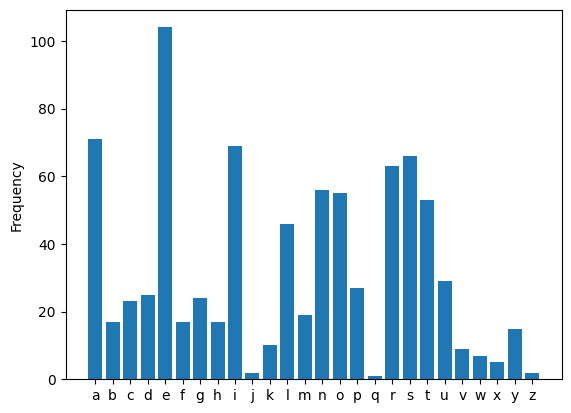

In [3]:
# plot occurences

plt.bar(list(alphabet), alphabetOccurences.values())
plt.ylabel("Frequency")

In [4]:
# get the distribution for each letter
alphabet_distributions = []

for char in alphabet:
    arr = [0 for i in range(8)]
    for word in words:
        count = word.count(char)
        arr[count] += 1
    alphabet_distributions.append(arr)

In [5]:
# get probabilities for each letter
alphabet_probabilities = np.array(alphabet_distributions)/len(words)
alphabet_probabilities[0]

array([0.52884615, 0.28846154, 0.15384615, 0.02884615, 0.        ,
       0.        , 0.        , 0.        ])

In [6]:
# simulation functions

# simulate 1 day
def simulate_scenario(stock):
    # get random word to be ordered
    scenario = 0
    word_ordered = words[random.randint(0, len(words) - 1)]

    # get letters from stock
    letters_obtained = []
    letters_needed = list(word_ordered)
    for letter in letters_needed:
        if(stock[letter] > 0):
            letters_obtained.append(letter)
            stock[letter] -= 1
    
    # check whether we can complete the word or not
    word_delivered = False
    if(len(letters_needed) == len(letters_obtained)):
        # we have enough letters to complete the word
        scenario = 1
    elif(len(letters_needed) == len(letters_obtained) + 1):
        # we are one letter short to complete the word, express ship
        scenario = 2
    else:
        scenario = 3

    # restock letters if we sold the word
    for letter in letters_obtained:
        stock[letter] += 1

    return scenario

# simulate multiple days and output probabilities
def simulate_scenarios(stock, iterations=10000):
    result = []
    test_stock = {char: 2 for char in alphabet}

    for i in range(iterations):
        result.append(simulate_scenario(stock))

    sc1_simulated = result.count(1)/iterations
    sc2_simulated = result.count(2)/iterations
    sc3_simulated = result.count(3)/iterations

    print("P(scenario 1): ", sc1_simulated)
    print("P(scenario 2): ", sc2_simulated)
    print("P(scenario 3): ", sc3_simulated)

    return result

# simulate the first week w times, and output averaged profit,
# including upfront costs
def simulate_profit(stock, weeks=1):
    profits = []
    for w in range(weeks):
        scenarios = []
        for i in range(5):
            scenarios.append(simulate_scenario(stock))

        profit = -1000*sum(stock.values())
        for sc in scenarios:
            if sc == 1:
                profit += 12000
            elif sc == 2:
                profit += 10000
            elif sc == 3:
                profit -= 10000

        profits.append(profit)

    return sum(profits)/weeks


In [7]:
# calculations using probability, functions

# calculate the probability of scenario 1
def calculate_sc1(stock):
    result = 1
    for i in range(26):
        current_p = 0
        for j in range(stock[i] + 1):
            #print(i, j)
            current_p += alphabet_probabilities[i][j]
        result *= current_p
    return result

# calculate the probability of scenario 2
def calculate_sc2(stock):
    result = 0
    for i in range(26):
        current_p = alphabet_probabilities[i][stock[i]+1]
        inner_p = 1
        for j in range(26):
            if (j != i):
                inner_p *= 1 - alphabet_probabilities[j][stock[i]+1]
        current_p *= inner_p
        result += current_p
    return result

# calculate the probabilites for all 3 scenarios
def calculate_scenarios(stock, logging=False):
    s1 = calculate_sc1(stock)
    s2 = calculate_sc2(stock)
    s3 = 1 - s1 - s2

    if(logging):
        print("P(scenario 1): ", s1)
        print("P(scenario 2): ", s2)
        print("P(scenario 3): ", s3)

    return (s1, s2, s3)

# calculate the profit given a stock
def calculate_profit(stock, logging=False):
    p = calculate_scenarios(stock, logging)
    return -1000*sum(stock) + 5*(12000*p[0] + 10000*p[1] - 10000*p[2])

In [8]:
# test simulations

x = {char: 2 for char in alphabet}
xd = simulate_scenarios(x)

P(scenario 1):  0.8963
P(scenario 2):  0.1037
P(scenario 3):  0.0


In [19]:
# test calculations

x = [1 for char in alphabet]
#p_scenarios = calculate_scenarios(x)

calculate_profit(x, True)

P(scenario 1):  0.2808006861011127
P(scenario 2):  0.3876523723132751
P(scenario 3):  0.33154694158561215


-6346.687297550088

In [29]:
# gradient ascent function

def gradient_ascent(guess_stock, max_iterations=100):

    # initialise guess
    current_stock = guess_stock
    current_profit = 0
    iterations = 1

    while(iterations<max_iterations):
        print("i = ", iterations)
        # track absolute differences in profit as we increase every
        # letter in the stock up by 1, or down by 1
        up = []
        down = []
        current_profit = calculate_profit(current_stock)

        # up and down
        test_stock = current_stock[:]
        for i in range(26):
            # up
            test_stock = current_stock[:]
            test_stock[i] = test_stock[i] + 1
            test_profit = calculate_profit(test_stock)
            up.append(test_profit - current_profit)

            # down
            test_stock = current_stock[:]
            if(test_stock[i] >= 0):
                test_stock[i] = test_stock[i] - 1
                test_profit = calculate_profit(test_stock)
                down.append(test_profit - current_profit)
            else:
                down.append(None)

        # get indexes of the max value
        up_max_idx = up.index(max(up))
        down_max_idx = down.index(max(down))

        print("Up dP maximum of ", max(up), " at ", alphabet[up_max_idx], " (", up_max_idx, ")")
        print("Down dP maximum of ", max(down), " at ", alphabet[down_max_idx], " (", down_max_idx, ")")

        # the index of the largest maximum value is permanently incremented
        # for the next iteration
        if(max(up) <= 0 and max(down) <= 0):
            print("No positive difference found at iteration ", i)
            print("Final stock: ", current_stock)
            print("Final profit: ", current_profit)
            return current_stock
        elif (max(up) > max(down)):
            # use up value
            current_stock[up_max_idx] += 1
        else:
            # use down value
            current_stock[down_max_idx] -= 1
        
        print("Current stock: ", current_stock)   

        iterations += 1
    
    print("Iteration limit exceeded")
    print("Final stock: ", current_stock)
    print("Final profit: ", current_profit)
    return current_stock


In [30]:
# perform gradient ascent to find optima

x = [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0]

best = gradient_ascent(x)

i =  1
Up dP maximum of  1898.1886894301279  at  l  ( 11 )
Down dP maximum of  1000.0  at  b  ( 1 )
Current stock:  [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0]
i =  2
Up dP maximum of  2329.183363017888  at  r  ( 17 )
Down dP maximum of  1000.0  at  b  ( 1 )
Current stock:  [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 1, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0]
i =  3
Up dP maximum of  3242.679921173338  at  t  ( 19 )
Down dP maximum of  1000.0  at  b  ( 1 )
Current stock:  [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0]
i =  4
Up dP maximum of  2031.9334017734218  at  u  ( 20 )
Down dP maximum of  1000.0  at  b  ( 1 )
Current stock:  [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0]
i =  5
Up dP maximum of  2359.0412970823672  at  p  ( 15 )
Down dP maximum of  1000.0  at  b  ( 1 )
Current stock:  [1, 5, 5, 0, 1, 0, 3, 0, 1, 0, 5, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0]
i =  6
Up dP maximum of  26

In [12]:
calculate_profit(best)

16480.551350090238

In [31]:
# simulate profit to compare to calculated profit

best_test = {char: b for char, b in zip(alphabet, best)}
print(best_test)

simulate_profit(best_test, 1000000)

{'a': 2, 'b': 2, 'c': 1, 'd': 1, 'e': 2, 'f': 2, 'g': 2, 'h': 1, 'i': 2, 'j': 0, 'k': 1, 'l': 2, 'm': 2, 'n': 2, 'o': 2, 'p': 2, 'q': 0, 'r': 2, 's': 2, 't': 2, 'u': 2, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}


17736.072

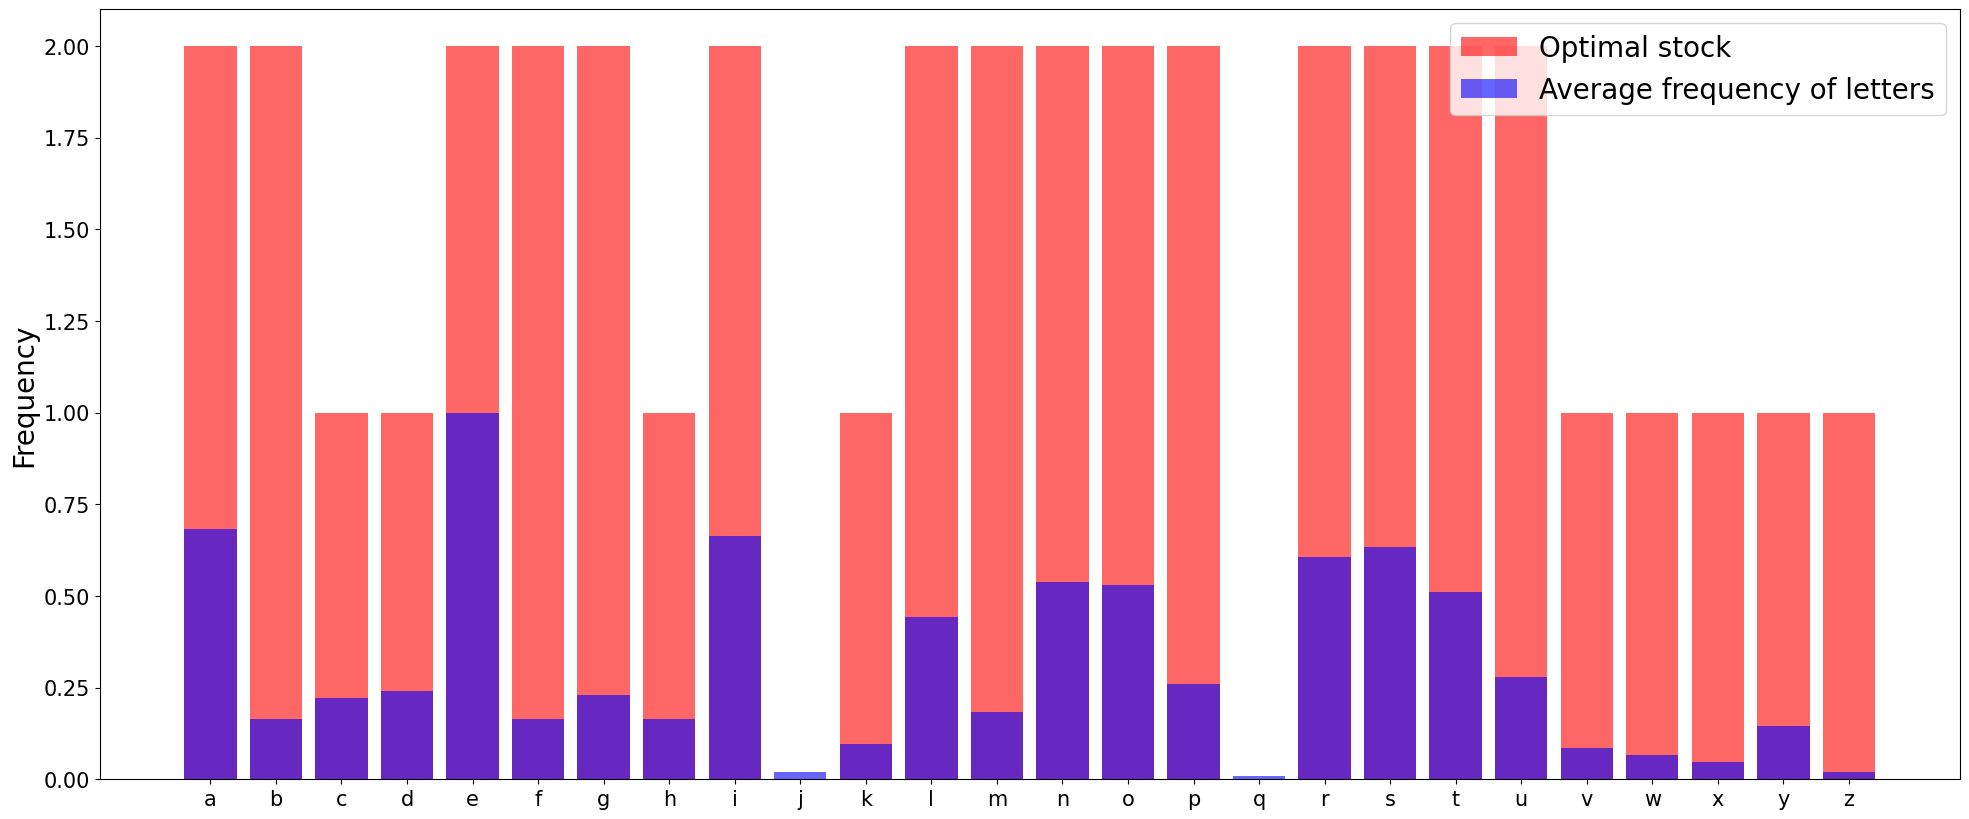

In [34]:
import matplotlib.pyplot as plt

averageAlphabetOccurences = np.array(list(alphabetOccurences.values()))/len(words)

fig,ax = plt.subplots(figsize=(24,10))

ax.bar(list(alphabet), best, color = 'r', alpha = 0.6, label="Optimal stock")
ax.bar(list(alphabet), averageAlphabetOccurences, color='b', alpha=0.6, label="Average frequency of letters")
ax.set_ylabel("Frequency",fontsize = 20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=20)
